In [1]:
## Importing needed packages
import pandas as pd
import sklearn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import patchify
from patchify import patchify
import tkinter as tk
import tkinter.filedialog as fd






In [5]:
root = tk.Tk()
filez = fd.askopenfilenames(parent=root, title='Choose a file')


In [6]:
dataz = []
for file in filez:
    data = pd.read_csv(file)
    data = data.iloc[:,1:]
    data.columns = ["X","Y","Val"]
    data.iloc[:,2] = ((data.Val - data.Val.min() )/ (data.Val.max()-data.Val.min())) 
    #new_data = data[(data['X']>(data.X.min()+data.X.std())) & (data["X"]<(data.X.median()))]
    dataz.append(data)

   

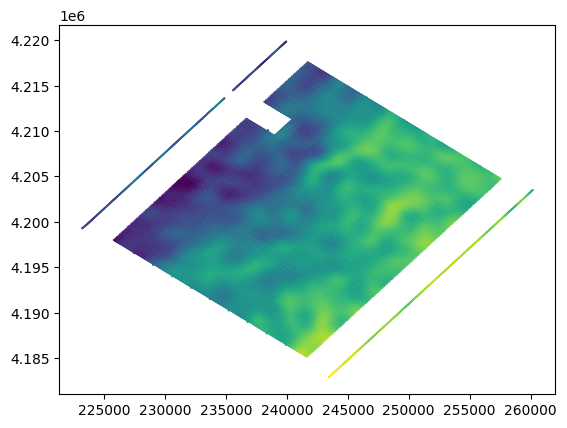

In [10]:
plt.scatter(dataz[0].X, dataz[0].Y, s = 0.1, c = dataz[0].Val)


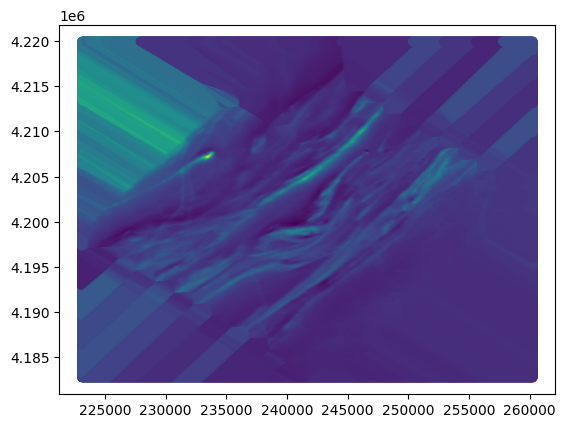

In [7]:


xspacing = np.linspace(data.X.min(), data.X.max(), 1000)
yspacing = np.linspace(data.Y.min(), data.Y.max(), 1000)
xgrid,ygrid = np.meshgrid(xspacing,yspacing)
interpmagvals = griddata((data.X,data.Y),data.Val,(xgrid,ygrid),method='nearest')
plt.scatter(xgrid,ygrid, c = interpmagvals)

def bounding_box(data):
    min

    return [(min(x_coordinates), min(y_coordinates)), (max(x_coordinates), max(y_coordinates))]



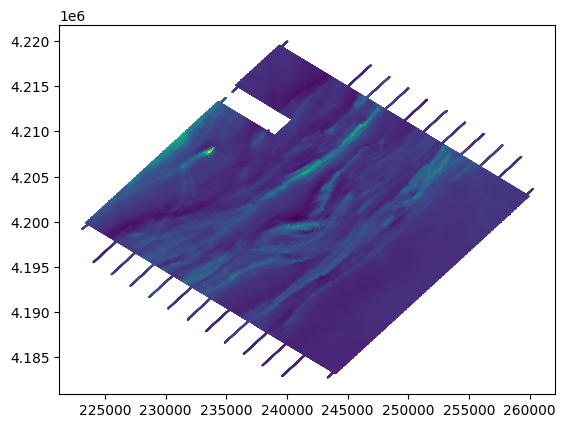

In [8]:
plt.scatter(dataz[1].X, dataz[1].Y, s = 0.1, c = dataz[1].Val)
plt.show()

In [ ]:
## Import data, drop all but Northing, Easting and Mag vals cols, note this is hardcoded to specific data 
gravdata = pd.read_csv('matagami_corrected.csv',skiprows = 8)
gravdata = gravdata.iloc[:,[22,23,19]]


## Trimmed data to a rectangle, arbitrary trimming extents, normalize mag vals to have max vals of 1 and min vals of 0
gravdata_trim = gravdata[(gravdata['X']>(gravdata.X.min()+gravdata.X.std())) & (gravdata["X"]<(gravdata.X.median()))]
gravdata_trim.iloc[:,2] = ((gravdata_trim.Mag - gravdata_trim.Mag.min() )/ (gravdata_trim.Mag.max()-gravdata_trim.Mag.min())) 
gravdata_trim.describe()
## orginal data
plt.scatter(gravdata.X, gravdata.Y, s = 0.001, c = gravdata.Mag)
plt.show()
## trimmed data
plt.scatter(gravdata_trim.X, gravdata_trim.Y, s = 0.1, c = gravdata_trim.Mag)
plt.show()
##create grid to interpolate data to, arbitrary choice of grid and increment size, 1000 evenly spaced points in between min and max vals
xlength = 1000
ylength = xlength
xspacing = np.linspace(gravdata_trim.X.min(), gravdata_trim.X.max(), xlength)
yspacing = np.linspace(gravdata_trim.Y.min(), gravdata_trim.Y.max(), ylength)
xgrid,ygrid = np.meshgrid(xspacing,yspacing)

#Interpolate values to grid, 1st arg is input coords, 2nd is input vals, 3rd is coords of output, 4th is method, current choice is nearest, to be changed
interpmagvals = griddata((gravdata_trim.X,gravdata_trim.Y),gravdata_trim.Mag,(xgrid,ygrid),method='nearest')
plt.scatter(xgrid,ygrid, c = interpmagvals)
interpmagvals.shape
# playing around with patchify
studyarealength = 100 #arbitrary study size chosen, this is used to make the length and width of my patches
magpatches = patchify(interpmagvals,(studyarealength,studyarealength),step=int(studyarealength*.5))#set to have an 50% overlap 
originalshape = magpatches.shape
xpatches = patchify(xgrid,(studyarealength,studyarealength),step=int(studyarealength*.2))#just made for visualizing purposes
ypatches = patchify(ygrid,(studyarealength,studyarealength),step=int(studyarealength*.2))
linearpatches = np.reshape(magpatches,(magpatches.shape[0]*magpatches.shape[1],studyarealength,studyarealength))#reshaped patches from 4D to 3D, a linear array of the patches
print(linearpatches[1,1,:] == magpatches[0,1,1,:])#used for verifying the patches were preserved through the reshape
linearpatches.shape
# playing around with train test split, for now splitting 
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(linearpatches, test_size=0.2, random_state=42)
X_test.shape
# Building model 
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model
# function to build an autoencoder
def build_autoencoder(img_shape, code_size): #image shape is size of image ie 32 x 32 x 3 (RGB), code size is the size of the compressed representation
    encoder = Sequential() #allows us to add layers to model
    encoder.add(InputLayer(img_shape)) #input image 
    encoder.add(Flatten()) #converts 3-D matrix to 1-D
    encoder.add(Dense(code_size)) #encoding layer, here we can set the number of neurons (code_size)

    decoder = Sequential() #creates decoder
    decoder.add(InputLayer((code_size,))) #input layer for the decoder, takes input from the encoder
    decoder.add(Dense(np.prod(img_shape))) #recreates image, reshapes back to original size
    decoder.add(Reshape(img_shape)) #puts it back into the form of an image, will need to research more here

    return encoder, decoder

# Calling function to build encoder and decoder
# gets patch shape from linearpatches, ignoring 0th index which is number of patches
IMG_SHAPE = (linearpatches.shape[1:])
encoder, decoder = build_autoencoder(IMG_SHAPE, 50) #calls function to build encoder and decoder, arbitrary code size set

inp = Input(IMG_SHAPE) #creates input tensor for encoder, of size (None, dimx, dimy, dimz)
code = encoder(inp) #passes input to encoder
reconstruction = decoder(code) #passes the encoded representation to the decoder as an input

autoencoder = Model(inp,reconstruction) #links encoder and decoder and their internallayers together to form a model, passed the input tensor and output tensor
autoencoder.compile(optimizer='adamax', loss='mse') #specifies how loss function (how model will evaluate cost function, here we use mse) and how to optimize 
#parameters, here we use adamaz, a form of algorithim for finding the global minimum of a function, can alter adamax learning_rate, default is .001

print(autoencoder.summary()) #shows shape and number of parameters at each step in model

#fitting the model, storing the results over the training epochs in the history variable
history = autoencoder.fit(x=X_train, y=X_train, epochs=4, validation_data=[X_test, X_test])
#plotting the training results, recall the loss function is mse as defined above
plt.plot(history.history['loss']) #mse from training data
plt.plot(history.history['val_loss']) #mse from validation data
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# function to visualize the results from the model
def visualize(img,encoder,decoder):
    code = encoder.predict(img[None])[0] #calls the encoder sequential model to make a compressed representation, [0] passes only the first patch to it 
    reco = decoder.predict(code[None])[0] #passes compressed rep to the decoder, returns the reconstructed image as a 3d array (shape 1,100,100), indexed [0] to give 2d array result

    #show the original patch
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    #show the activations of the compressed representation
    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    #show the reconstructed patch
    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco)
    plt.show()


#call visualize function in a loop to see the results
# for i in [1,1000]:
#     img = X_test[i]
#     visualize(img,encoder,decoder)
code = encoder.predict(linearpatches[None][0]) 
code.shape
# while loop to pass all patches through the encoder and decoder, then store them in a new linear set of patches
#Might be a way to vectorize this to make it more efficient
from sklearn.metrics import mean_squared_error
i = 0
maxdim = linearpatches.shape[0] #longest dimension of the linearpatches 
mse = np.empty((maxdim))
while i < maxdim:
    code = encoder.predict(linearpatches[None][0])#calls the encoder sequential model to make a compressed representation
    patchcode = code[i,:] #takes the ith compressed patch 
    reco = decoder.predict(patchcode[None])[0]#passes ith patch compressed rep to the decoder
    if i == 0: #for the first iteration, make a variable to store the reconstructed patches, assign the patch to te first index
        linearrecon = np.empty((maxdim,studyarealength,studyarealength)) 
        linearrecon[i] = np.reshape(reco, (1,studyarealength,studyarealength)) #had to reshape to put the 2D array into the 3D array of patches
    else:
        linearrecon[i] = reco #after the first iteration, put the ith reconstructed patch in the ith pos in the linearrecon variable
    mse[i] = mean_squared_error(linearpatches[i],linearrecon[i])
    i += 1

#reshaping the reconstructed patches to the original shape
reshapedrecon = np.reshape(linearrecon,originalshape)
reconimage = unpatchify(reshapedrecon,(xlength,ylength))

#Plot the original interpolated values
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(interpmagvals)

#Plot the reconstructed patches 
plt.subplot(1,2,2)
plt.title("Reconstructed")
plt.imshow(reconimage)


#this returns a sorted array, lowest mse to greatest, but is an array of indicies, not values, so sortedidx[0] is the index of the lowest mse
# by going mse[sortedidx[-5:]], you can get the top 5 mse vals
sortedidx= np.argsort(mse) 
top5anomsidx = sortedidx[-5:]
top5anomsmse = mse[top5anomsidx]

# reshape mse array for it to be plotted, plot the mse with a colout bar
reshapedmse = mse.reshape((magpatches.shape[0],magpatches.shape[1]))
plt.title("MSE of Each Patch")
im =plt.imshow(reshapedmse)
plt.colorbar(mappable=im, label = 'MSE')